# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ColabNotebooks/data/Deep_learning

import os
print("Now in:", os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/data/Deep_learning
Now in: /content/drive/MyDrive/ColabNotebooks/data/Deep_learning


Download data with kagglehub

In [4]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [5]:
dataset = FashionDataset("dataset/train.csv",img_dir)
#dataset = FashionDataset("train.csv",img_dir)

In [ ]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


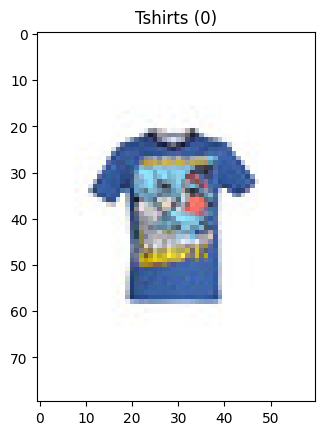

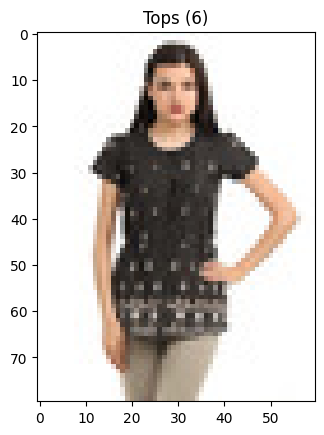

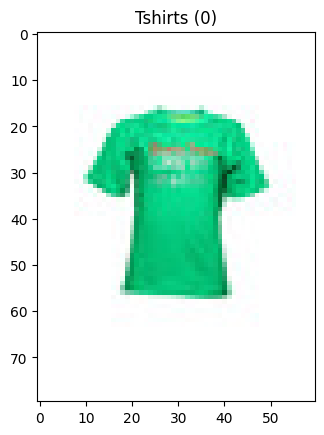

In [ ]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [6]:
transform = transforms.Compose([
    transforms.Resize((80, 80)), #resize to 80x80, because the original images have different sizes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)

# train_dataset = FashionDataset("train.csv",img_dir,transform=transform)
# main_test_dataset =  FashionDataset("main_test.csv",img_dir,transform=transform)
# new_test_dataset =  FashionDataset("new_test.csv",img_dir,transform=transform)
# main_support_dataset =  FashionDataset("main_support.csv",img_dir,transform=transform)
# new_support_dataset =  FashionDataset("new_support.csv",img_dir,transform=transform)
# merged_test_dataset =  FashionDataset("merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
# merged_support_dataset =  FashionDataset("merged_support.csv",img_dir,transform=transform)

# # datasets with categories
# main_test_dataset_cat =  FashionDataset("main_test.csv",img_dir,column_class="categoryId",transform=transform)
# main_support_dataset_cat =  FashionDataset("main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)}
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [7]:
#IMPORT ALL THE REQUIRED LIBRARIES

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier


### Model Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes, bw = 32, lr= 0.001):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3,  bw,  kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),

            nn.Conv2d(bw, bw, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),

            nn.Conv2d(bw*2, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw*2, bw*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*4),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p = 0.3),
            nn.Linear(bw*4, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x




### Helper Functions

In [ ]:
#import with data loaders
def get_data(train_ds, valid_ds, batch_size=64):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_dl, valid_dl

def loss_batch(model, loss_func, xb, yb, opt=None):

    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)


    return loss.item(), corrects, len(xb), preds, yb


def fit(epochs, model, loss_func, opt, scheduler, train_dl, valid_dl):
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    train_accs = []
    val_accs = []

    for epoch in tqdm(range(epochs)):


        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:

            # move data to GPU if available
            xb = xb.to(device)
            yb = yb.to(device)

            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums, *_ = loss_batch(model, loss_func, xb, yb,opt)

            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num
        train_accs.append(train_acc)


        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0

            all_preds, all_trues = [], []

            for xb, yb in valid_dl:

                xb = xb.to(device)
                yb = yb.to(device)


                # forward
                losses, corrects, nums, preds, yb = loss_batch(model, loss_func, xb, yb)

                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

                all_preds.append(preds.cpu())
                all_trues.append(yb.cpu())



            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            bacc = balanced_accuracy_score(torch.cat(all_trues), torch.cat(all_preds))

            val_accs.append(val_acc)

            scheduler.step(val_loss) # decrease the learning rate if validation loss increases


        # print the results
        print(
            f'EPOCH with LR {scheduler.get_last_lr()[0]}: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ', f"VAL-BACC: {bacc:.4f} ",end='\n')

        if val_acc >= 0.8 and bacc >= 0.8:
          print("Early Stopping")
          break

    plot_train(train_accs, val_accs)



### Learning curve


In [ ]:
def plot_train(train_accs, test_accs):
      fig, ax = plt.subplots(figsize=(8,6))
      fnt=16
      ax.plot(train_accs, color='blue', label='Train')
      ax.plot(test_accs, color='red', linestyle='--', label='Test')
      ax.legend(fontsize=fnt)
      ax.tick_params(axis='both', labelsize=fnt)
      ax.set_xlabel('Epoch', fontsize=fnt)
      ax.set_ylabel('Accuracy', fontsize=fnt)

### Training the model

In [ ]:
epochs=100
lr = 0.01

model = CNN(num_classes=39)
# OPTIONAL: load pretrained weights from an earlier run
# model.load_state_dict(torch.load('models/fashion_model_weights.pth'))

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5) # decrease the learning rate if validation loss increases
loss_func = F.cross_entropy

train_dl, valid_dl = get_data(train_dataset, main_test_dataset, batch_size=526) # you have to decrease batch size for lower RAM gpus/cpus


fit(epochs, model, loss_func, opt, scheduler, train_dl, valid_dl)

Using device: cuda


  1%|          | 1/100 [00:47<1:18:06, 47.33s/it]

EPOCH with LR 0.01: 001/100 LOSS: 2.9703 ACC: 0.2288  VAL-LOSS: 2.6714 VAL-ACC: 0.2919  VAL-BACC: 0.0818 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  2%|▏         | 2/100 [01:20<1:03:19, 38.77s/it]

EPOCH with LR 0.01: 002/100 LOSS: 2.4071 ACC: 0.3503  VAL-LOSS: 2.5992 VAL-ACC: 0.2479  VAL-BACC: 0.0779 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  3%|▎         | 3/100 [01:51<57:32, 35.59s/it]  

EPOCH with LR 0.01: 003/100 LOSS: 2.1194 ACC: 0.4209  VAL-LOSS: 2.1386 VAL-ACC: 0.3886  VAL-BACC: 0.1557 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  4%|▍         | 4/100 [02:24<55:11, 34.49s/it]

EPOCH with LR 0.01: 004/100 LOSS: 1.9152 ACC: 0.4746  VAL-LOSS: 2.0244 VAL-ACC: 0.4397  VAL-BACC: 0.2112 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  5%|▌         | 5/100 [02:56<53:06, 33.54s/it]

EPOCH with LR 0.01: 005/100 LOSS: 1.7365 ACC: 0.5243  VAL-LOSS: 1.7379 VAL-ACC: 0.5138  VAL-BACC: 0.2500 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  6%|▌         | 6/100 [03:29<52:01, 33.21s/it]

EPOCH with LR 0.01: 006/100 LOSS: 1.5840 ACC: 0.5602  VAL-LOSS: 2.0054 VAL-ACC: 0.4362  VAL-BACC: 0.2698 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  7%|▋         | 7/100 [04:01<50:47, 32.77s/it]

EPOCH with LR 0.01: 007/100 LOSS: 1.4625 ACC: 0.5941  VAL-LOSS: 4.5380 VAL-ACC: 0.2419  VAL-BACC: 0.0666 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  8%|▊         | 8/100 [04:34<50:25, 32.89s/it]

EPOCH with LR 0.01: 008/100 LOSS: 1.3637 ACC: 0.6143  VAL-LOSS: 5.1572 VAL-ACC: 0.3080  VAL-BACC: 0.1103 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  9%|▉         | 9/100 [05:06<49:43, 32.79s/it]

EPOCH with LR 0.01: 009/100 LOSS: 1.2651 ACC: 0.6398  VAL-LOSS: 1.8566 VAL-ACC: 0.4457  VAL-BACC: 0.2255 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 10%|█         | 10/100 [05:37<48:25, 32.28s/it]

EPOCH with LR 0.01: 010/100 LOSS: 1.1946 ACC: 0.6539  VAL-LOSS: 1.6040 VAL-ACC: 0.5238  VAL-BACC: 0.3152 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 11%|█         | 11/100 [06:10<48:02, 32.39s/it]

EPOCH with LR 0.01: 011/100 LOSS: 1.1427 ACC: 0.6666  VAL-LOSS: 2.5108 VAL-ACC: 0.3771  VAL-BACC: 0.2211 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 12%|█▏        | 12/100 [06:41<47:02, 32.07s/it]

EPOCH with LR 0.01: 012/100 LOSS: 1.0875 ACC: 0.6809  VAL-LOSS: 5.7916 VAL-ACC: 0.1793  VAL-BACC: 0.0978 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 13%|█▎        | 13/100 [07:14<46:36, 32.15s/it]

EPOCH with LR 0.01: 013/100 LOSS: 1.0372 ACC: 0.6941  VAL-LOSS: 1.9116 VAL-ACC: 0.4842  VAL-BACC: 0.2805 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 14%|█▍        | 14/100 [07:45<45:45, 31.93s/it]

EPOCH with LR 0.01: 014/100 LOSS: 0.9982 ACC: 0.7050  VAL-LOSS: 2.7653 VAL-ACC: 0.3485  VAL-BACC: 0.1696 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 15%|█▌        | 15/100 [08:18<45:26, 32.08s/it]

EPOCH with LR 0.01: 015/100 LOSS: 0.9616 ACC: 0.7146  VAL-LOSS: 2.6905 VAL-ACC: 0.3786  VAL-BACC: 0.1826 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 16%|█▌        | 16/100 [08:51<45:20, 32.39s/it]

EPOCH with LR 0.001: 016/100 LOSS: 0.9336 ACC: 0.7231  VAL-LOSS: 1.9002 VAL-ACC: 0.4542  VAL-BACC: 0.2380 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 17%|█▋        | 17/100 [09:24<45:07, 32.62s/it]

EPOCH with LR 0.001: 017/100 LOSS: 0.8702 ACC: 0.7400  VAL-LOSS: 0.8922 VAL-ACC: 0.7246  VAL-BACC: 0.5124 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 18%|█▊        | 18/100 [09:56<44:31, 32.58s/it]

EPOCH with LR 0.001: 018/100 LOSS: 0.8558 ACC: 0.7465  VAL-LOSS: 0.8096 VAL-ACC: 0.7672  VAL-BACC: 0.5711 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 19%|█▉        | 19/100 [10:29<44:09, 32.72s/it]

EPOCH with LR 0.001: 019/100 LOSS: 0.8499 ACC: 0.7476  VAL-LOSS: 0.8768 VAL-ACC: 0.7346  VAL-BACC: 0.5425 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 20%|██        | 20/100 [11:03<43:49, 32.87s/it]

EPOCH with LR 0.001: 020/100 LOSS: 0.8425 ACC: 0.7505  VAL-LOSS: 0.8356 VAL-ACC: 0.7576  VAL-BACC: 0.5813 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 21%|██        | 21/100 [11:34<42:46, 32.48s/it]

EPOCH with LR 0.001: 021/100 LOSS: 0.8410 ACC: 0.7507  VAL-LOSS: 0.8130 VAL-ACC: 0.7621  VAL-BACC: 0.5794 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 22%|██▏       | 22/100 [12:07<42:12, 32.47s/it]

EPOCH with LR 0.001: 022/100 LOSS: 0.8351 ACC: 0.7542  VAL-LOSS: 0.8337 VAL-ACC: 0.7486  VAL-BACC: 0.5675 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 23%|██▎       | 23/100 [12:39<41:30, 32.34s/it]

EPOCH with LR 0.001: 023/100 LOSS: 0.8318 ACC: 0.7544  VAL-LOSS: 0.8480 VAL-ACC: 0.7551  VAL-BACC: 0.5715 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 24%|██▍       | 24/100 [13:12<41:29, 32.76s/it]

EPOCH with LR 0.001: 024/100 LOSS: 0.8266 ACC: 0.7567  VAL-LOSS: 0.8044 VAL-ACC: 0.7536  VAL-BACC: 0.5534 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 25%|██▌       | 25/100 [13:44<40:29, 32.39s/it]

EPOCH with LR 0.001: 025/100 LOSS: 0.8279 ACC: 0.7535  VAL-LOSS: 0.8744 VAL-ACC: 0.7306  VAL-BACC: 0.5191 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 26%|██▌       | 26/100 [14:17<40:10, 32.58s/it]

EPOCH with LR 0.001: 026/100 LOSS: 0.8230 ACC: 0.7570  VAL-LOSS: 0.7730 VAL-ACC: 0.7782  VAL-BACC: 0.5921 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 27%|██▋       | 27/100 [14:49<39:26, 32.42s/it]

EPOCH with LR 0.001: 027/100 LOSS: 0.8205 ACC: 0.7567  VAL-LOSS: 0.7836 VAL-ACC: 0.7697  VAL-BACC: 0.5829 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 28%|██▊       | 28/100 [15:21<38:54, 32.43s/it]

EPOCH with LR 0.001: 028/100 LOSS: 0.8156 ACC: 0.7589  VAL-LOSS: 0.8316 VAL-ACC: 0.7581  VAL-BACC: 0.5768 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 29%|██▉       | 29/100 [15:54<38:26, 32.48s/it]

EPOCH with LR 0.001: 029/100 LOSS: 0.8153 ACC: 0.7589  VAL-LOSS: 0.8088 VAL-ACC: 0.7606  VAL-BACC: 0.5699 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 30%|███       | 30/100 [16:26<37:44, 32.35s/it]

EPOCH with LR 0.001: 030/100 LOSS: 0.8074 ACC: 0.7599  VAL-LOSS: 0.7646 VAL-ACC: 0.7787  VAL-BACC: 0.6015 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 31%|███       | 31/100 [16:59<37:30, 32.61s/it]

EPOCH with LR 0.001: 031/100 LOSS: 0.8053 ACC: 0.7616  VAL-LOSS: 0.9505 VAL-ACC: 0.6870  VAL-BACC: 0.4389 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 32%|███▏      | 32/100 [17:31<36:32, 32.25s/it]

EPOCH with LR 0.001: 032/100 LOSS: 0.8033 ACC: 0.7610  VAL-LOSS: 0.7903 VAL-ACC: 0.7712  VAL-BACC: 0.6025 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 33%|███▎      | 33/100 [18:03<35:56, 32.19s/it]

EPOCH with LR 0.001: 033/100 LOSS: 0.7985 ACC: 0.7646  VAL-LOSS: 1.2810 VAL-ACC: 0.5954  VAL-BACC: 0.3472 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 34%|███▍      | 34/100 [18:34<35:15, 32.05s/it]

EPOCH with LR 0.001: 034/100 LOSS: 0.7953 ACC: 0.7642  VAL-LOSS: 0.7717 VAL-ACC: 0.7787  VAL-BACC: 0.5967 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 35%|███▌      | 35/100 [19:06<34:43, 32.06s/it]

EPOCH with LR 0.001: 035/100 LOSS: 0.7906 ACC: 0.7649  VAL-LOSS: 0.7940 VAL-ACC: 0.7511  VAL-BACC: 0.5502 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 36%|███▌      | 36/100 [19:38<34:06, 31.98s/it]

EPOCH with LR 0.0001: 036/100 LOSS: 0.7897 ACC: 0.7641  VAL-LOSS: 0.7985 VAL-ACC: 0.7581  VAL-BACC: 0.5685 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 37%|███▋      | 37/100 [20:11<33:50, 32.24s/it]

EPOCH with LR 0.0001: 037/100 LOSS: 0.7794 ACC: 0.7705  VAL-LOSS: 0.7379 VAL-ACC: 0.7852  VAL-BACC: 0.6049 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 38%|███▊      | 38/100 [20:43<33:09, 32.10s/it]

EPOCH with LR 0.0001: 038/100 LOSS: 0.7781 ACC: 0.7701  VAL-LOSS: 0.7368 VAL-ACC: 0.7867  VAL-BACC: 0.6051 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 39%|███▉      | 39/100 [21:16<33:02, 32.50s/it]

EPOCH with LR 0.0001: 039/100 LOSS: 0.7777 ACC: 0.7677  VAL-LOSS: 0.7360 VAL-ACC: 0.7852  VAL-BACC: 0.6013 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 40%|████      | 40/100 [21:48<32:13, 32.23s/it]

EPOCH with LR 0.0001: 040/100 LOSS: 0.7776 ACC: 0.7700  VAL-LOSS: 0.7368 VAL-ACC: 0.7812  VAL-BACC: 0.5973 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 41%|████      | 41/100 [22:21<31:52, 32.41s/it]

EPOCH with LR 0.0001: 041/100 LOSS: 0.7781 ACC: 0.7675  VAL-LOSS: 0.7364 VAL-ACC: 0.7857  VAL-BACC: 0.6065 


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 41%|████      | 41/100 [22:44<32:43, 33.28s/it]


KeyboardInterrupt: 

### Saving the model

In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'models/fashion_model_weights.pth')

### Evaluate on test set

In [ ]:

def evaluate_model(model, test_dl):
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():  # No gradients needed for evaluation
        for x, y in test_dl:
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda()

            outputs = model(x)
            _, preds = torch.max(outputs, 1)

            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Calculate metrics
    accuracy = total_correct / total_samples
    balanced_acc = balanced_accuracy_score(all_targets, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    return accuracy, balanced_acc

# 1. Load your model and weights
model = CNN(num_classes=39)  # Initialize with the same architecture
# model.load_state_dict(torch.load('models/fashion_model_weights.pth'))
model.load_state_dict(torch.load('fashion_model_weights.pth'))

if torch.cuda.is_available():
    model = model.cuda()

# 2. Create dataloader for your test dataset
test_dl = DataLoader(main_test_dataset, batch_size=64, shuffle=False)

# 3. Evaluate on the new test dataset
accuracy, balanced_accuracy = evaluate_model(model, test_dl)

Test Accuracy: 0.8803
Balanced Accuracy: 0.8044


## Task 2

In [ ]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

Steps:

1. Define embedding (mapping) network  f(x)  - EmbeddingNet , to extract embedding of each sample (anchor, positive and negative image ) in triplets.

2. Create BalancedBatchSampler - samples  N  classes and  M  samples for each class to form a minibatch, and create a dataloader with the batch sampler.

3. Define a TripletSelector that return triplets combinations by the samples from BalancedBatchSampler

4. Define TripletLoss that will use a TripletSelector and compute TripletLoss on triplets

5. Train the network!

###  Embedding Net

In [8]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class EmbeddingNet(nn.Module):
    def __init__(self, bw = 32, lr= 0.001, embedding_dim=128):
        """CNN Builder."""
        super(EmbeddingNet, self).__init__()

        self.front_layer = nn.Sequential(
            nn.Conv2d(3,  bw,  kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),

            nn.Conv2d(bw, bw, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),

            nn.Conv2d(bw*2, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw*2, bw*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*4),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.embedding_layer = nn.Linear(bw*4, embedding_dim)

    def forward(self, x):
        features = self.front_layer(x)
        embedding = self.embedding_layer(features)
        embedding = F.normalize(embedding, p=2, dim=1)
        return embedding

    def get_embedding(self, x):
        return self.forward(x)


### Balanced Batch Sampler and Data Loader

In [9]:
from torch.utils.data.sampler import BatchSampler

class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [11]:
train_batch_sampler = BalancedBatchSampler(train_dataset.targets, n_classes=10, n_samples=100)
test_batch_sampler = BalancedBatchSampler(main_test_dataset.targets, n_classes=10, n_samples=100)

triplets_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
triplets_test_loader = torch.utils.data.DataLoader(main_test_dataset, batch_sampler=test_batch_sampler)

### Random Triplet Selector

In [10]:
from itertools import combinations

class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


In [12]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix
class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()

        self.margin = margin

   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):

        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None


    def get_triplets(self, embeddings, labels):

        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)


            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()

                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)

### Triplet Loss

In [13]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        anchor_idx= triplets[:, 0]
        anchor = embeddings[anchor_idx]

        positive_idx= triplets[:, 1]
        positive = embeddings[positive_idx]

        negative_idx= triplets[:, 2]
        negative = embeddings[negative_idx]

        # Distances
        pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
        neg_dist = torch.sum((anchor - negative) ** 2, dim=1)

        # # Finishe the triplet loss funtion: max(0, margin + pos_dist - neg_dist)
        losses = F.relu(self.margin + pos_dist - neg_dist)

        return losses.mean()

### Training the  model

In [14]:
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):

            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss

                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

In [15]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

# model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)


# margin value
margin=1

# criterion
criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin))

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=triplets_test_loader,
                  epochs=10)

# start training
trainer.run_trainer()

 10%|█         | 1/10 [06:04<54:43, 364.81s/it]

EPOCH: 01/10 LOSS: 0.8753 VAL-LOSS: 0.9407


 20%|██        | 2/10 [10:55<42:50, 321.30s/it]

EPOCH: 02/10 LOSS: 0.8256 VAL-LOSS: 0.8617


 30%|███       | 3/10 [15:32<35:05, 300.80s/it]

EPOCH: 03/10 LOSS: 0.8341 VAL-LOSS: 0.9798


 40%|████      | 4/10 [19:48<28:20, 283.44s/it]

EPOCH: 04/10 LOSS: 0.8699 VAL-LOSS: 0.9521


 50%|█████     | 5/10 [24:02<22:43, 272.61s/it]

EPOCH: 05/10 LOSS: 0.8429 VAL-LOSS: 0.7965


 60%|██████    | 6/10 [28:20<17:50, 267.70s/it]

EPOCH: 06/10 LOSS: 0.7922 VAL-LOSS: 0.6483


 70%|███████   | 7/10 [32:39<13:15, 265.03s/it]

EPOCH: 07/10 LOSS: 0.7775 VAL-LOSS: 0.7047


 80%|████████  | 8/10 [36:56<08:44, 262.18s/it]

EPOCH: 08/10 LOSS: 0.7418 VAL-LOSS: 0.8000


 90%|█████████ | 9/10 [41:13<04:20, 260.63s/it]

EPOCH: 09/10 LOSS: 0.7099 VAL-LOSS: 0.7732


100%|██████████| 10/10 [45:24<00:00, 272.42s/it]

EPOCH: 10/10 LOSS: 0.6726 VAL-LOSS: 0.6255


### Save the embedding model

In [16]:
torch.save(model.state_dict(), 'embedding_model.pth')

A help funtion to extract the embedding

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(main_test_dataset, batch_size=256)

def extract_embeddings(dataloader, model):

    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 128))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(train_loader, model)
val_embeddings, val_labels = extract_embeddings(test_loader, model)

### Visualize the embeddings in 2-d space

In [18]:
labels = list(label_id_to_label_name.values())

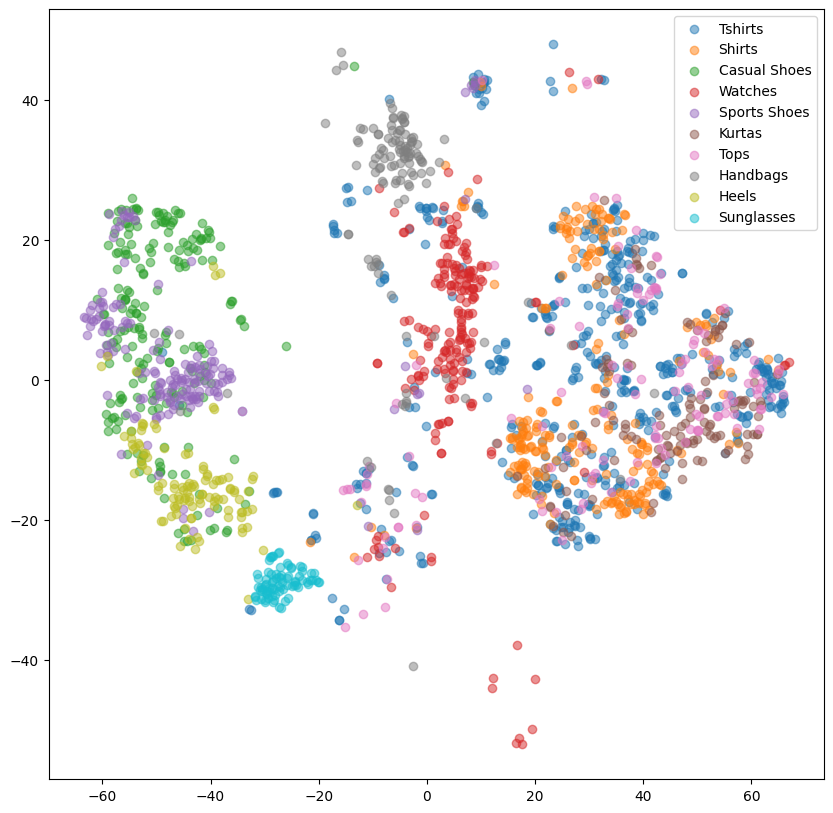

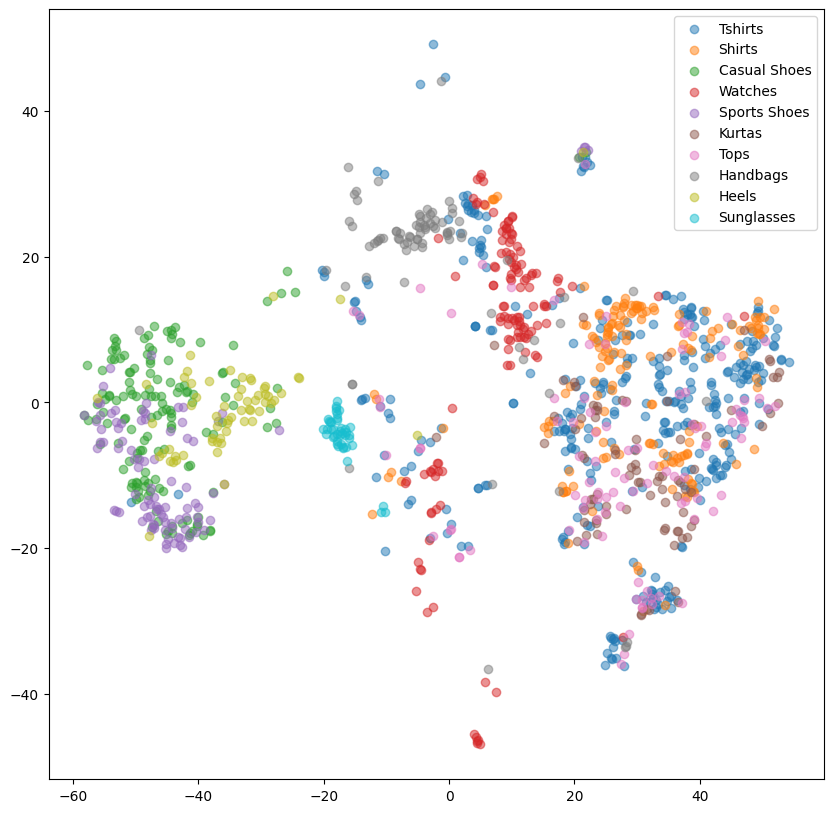

In [19]:
from sklearn.manifold import TSNE
def plot_tsne_embeddings(embeddings, targets, xlim=None, ylim=None):


    # The first 3000 embeddings and targets
    embeddings= embeddings[:3000]
    targets= targets[:3000]

    # Using Tsne to for dimension reduction
    tsne = TSNE(n_components=2)
    embeddings = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(labels)

plot_tsne_embeddings(train_embeddings, train_labels)
plot_tsne_embeddings(val_embeddings, val_labels)


Now we need to:
1. Compute the embeddings for the support set images.
2. Compute the embedding for the test set images
3. Find the k-nearest kneighbours from the support set
4. Classify the test images based on the labels from the k-nearest kneighbours (so we don't need to retrain the model and can classify unseen classes/labels)


### Load the embedding model

In [20]:
# Load the model
embedding_net = EmbeddingNet().to(device)
embedding_net.load_state_dict(torch.load('embedding_model.pth'))



<All keys matched successfully>

### Create embedding support classifier

In [21]:
class EmbeddingSupportClassifier:
    """
    A classifier that uses embeddings from a support set to classify test images.
    This allows classification of new classes without retraining the model.
    """
    def __init__(self, model, device, k=5):
        self.model = model
        self.device = device
        self.k = k
        self.knn = None
        self.support_embeddings = None
        self.support_labels = None

    def extract_embeddings(self, dataloader):
        self.model.eval()
        embeddings = []
        labels = []

        with torch.no_grad():
            for images, targets in tqdm(dataloader, desc="Extracting embeddings"):
                images = images.to(self.device)
                batch_embeddings = self.model.get_embedding(images).cpu().numpy()
                embeddings.append(batch_embeddings)
                labels.append(targets.numpy())

        embeddings = np.vstack(embeddings)
        labels = np.concatenate(labels)

        return embeddings, labels

    def fit_support_set(self, support_loader):
        print("Fitting support set...")
        self.support_embeddings, self.support_labels = self.extract_embeddings(support_loader)
        self.knn = KNeighborsClassifier(n_neighbors=self.k, metric='euclidean')
        self.knn.fit(self.support_embeddings, self.support_labels)
        print(f"Support set fitted with {len(self.support_labels)} samples")

    def predict(self, test_loader):
        if self.knn is None:
            raise ValueError("Support set must be fitted before prediction")

        test_embeddings, test_labels = self.extract_embeddings(test_loader)
        predicted_labels = self.knn.predict(test_embeddings)

        return test_labels, predicted_labels

    def evaluate(self, test_loader):
        true_labels, predicted_labels = self.predict(test_loader)

        acc = accuracy_score(true_labels, predicted_labels)
        balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

        return acc,balanced_acc

### Create dataloaders

In [22]:
batch_size=526
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
main_test_dl = DataLoader(main_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
new_test_dl = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
main_support_dl = DataLoader(main_support_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
new_support_dl = DataLoader(new_support_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
merged_test_dl = DataLoader(merged_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
merged_support_dl = DataLoader(merged_support_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


### Function to run all the scenarios

In [23]:
# Function to run all the scenarios
def evaluate_all_scenarios(model, device, k_values=[1, 5]):
    """
    Evaluate the model on all scenarios with different k values

    Args:
        model: Trained embedding model
        device: Device to run the model on
        k_values: List of k values to try for KNN

    Returns:
        best_results: Dictionary with best results for all scenarios
    """
    loaders = {
        'train': train_dl,
        'main_test': main_test_dl,
        'new_test': new_test_dl,
        'main_support': main_support_dl,
        'new_support': new_support_dl,
        'merged_test': merged_test_dl,
        'merged_support': merged_support_dl
    }

    best_results = {}
    best_k = {}

    for scenario_num, (support_name, test_name) in enumerate([
        ('train', 'main_test'),           # Scenario 1
        ('main_support', 'main_test'),    # Scenario 2
        ('new_support', 'new_test'),      # Scenario 3
        ('merged_support', 'merged_test') # Scenario 4
    ], 1):
        scenario_results = []

        for k in k_values:
            classifier = EmbeddingSupportClassifier(model, device, k=k)
            classifier.fit_support_set(loaders[support_name])
            acc, bal_acc = classifier.evaluate(loaders[test_name])
            scenario_results.append((k, acc, bal_acc))
            print(f"Scenario {scenario_num}, k={k}: Accuracy = {acc:.4f}, Balanced Accuracy = {bal_acc:.4f}")

        # Find best k based on balanced accuracy
        best_k_idx = np.argmax([r[2] for r in scenario_results])
        best_k[f'scenario{scenario_num}'] = scenario_results[best_k_idx][0]
        best_results[f'scenario{scenario_num}'] = {
            'k': scenario_results[best_k_idx][0],
            'accuracy': scenario_results[best_k_idx][1],
            'balanced_accuracy': scenario_results[best_k_idx][2]
        }

    # Print summary of best results
    print("\nBest Results Summary:")
    for scenario in range(1, 5):
        result = best_results[f'scenario{scenario}']
        print(f"Scenario {scenario}: Best k={result['k']}, Accuracy={result['accuracy']:.4f}, Balanced Accuracy={result['balanced_accuracy']:.4f}")

    return best_results, best_k

### Run all the scenarios

In [24]:
 # Evaluate all scenarios
best_results, best_k_values = evaluate_all_scenarios(
    embedding_net, device
)

Fitting support set...


Extracting embeddings: 100%|██████████| 69/69 [00:13<00:00,  5.00it/s]


Support set fitted with 35934 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Scenario 1, k=1: Accuracy = 0.7176, Balanced Accuracy = 0.6634
Fitting support set...


Extracting embeddings: 100%|██████████| 69/69 [00:13<00:00,  5.13it/s]


Support set fitted with 35934 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


Scenario 1, k=5: Accuracy = 0.7051, Balanced Accuracy = 0.6144
Fitting support set...


Extracting embeddings: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Support set fitted with 1996 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


Scenario 2, k=1: Accuracy = 0.5704, Balanced Accuracy = 0.4952
Fitting support set...


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Support set fitted with 1996 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


Scenario 2, k=5: Accuracy = 0.5704, Balanced Accuracy = 0.4403
Fitting support set...


Extracting embeddings: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Support set fitted with 1659 samples


Extracting embeddings: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Scenario 3, k=1: Accuracy = 0.6651, Balanced Accuracy = 0.6684
Fitting support set...


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


Support set fitted with 1659 samples


Extracting embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Scenario 3, k=5: Accuracy = 0.6476, Balanced Accuracy = 0.6170
Fitting support set...


Extracting embeddings: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


Support set fitted with 3655 samples


Extracting embeddings: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


Scenario 4, k=1: Accuracy = 0.5349, Balanced Accuracy = 0.4848
Fitting support set...


Extracting embeddings: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Support set fitted with 3655 samples


Extracting embeddings: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


Scenario 4, k=5: Accuracy = 0.5212, Balanced Accuracy = 0.4354

Best Results Summary:
Scenario 1: Best k=1, Accuracy=0.7176, Balanced Accuracy=0.6634
Scenario 2: Best k=1, Accuracy=0.5704, Balanced Accuracy=0.4952
Scenario 3: Best k=1, Accuracy=0.6651, Balanced Accuracy=0.6684
Scenario 4: Best k=1, Accuracy=0.5349, Balanced Accuracy=0.4848


In [25]:
# Print summary
print("\nEvaluation Summary:")
scenarios = [
    "Scenario 1: Main classes train → Main classes test",
    "Scenario 2: Main classes support → Main classes test",
    "Scenario 3: New classes support → New classes test",
    "Scenario 4: Main+New classes support → Main+New classes test"
]

# Display the results
for i, key in enumerate(best_results, 1):
    data = best_results[key]
    print(f"{scenarios[i - 1]}")
    print(f"  k: {data['k']}")
    print(f"  Accuracy: {data['accuracy']:.4f}")
    print(f"  Balanced Accuracy: {data['balanced_accuracy']:.4f}")
    print()



Evaluation Summary:
Scenario 1: Main classes train → Main classes test
  k: 1
  Accuracy: 0.7176
  Balanced Accuracy: 0.6634

Scenario 2: Main classes support → Main classes test
  k: 1
  Accuracy: 0.5704
  Balanced Accuracy: 0.4952

Scenario 3: New classes support → New classes test
  k: 1
  Accuracy: 0.6651
  Balanced Accuracy: 0.6684

Scenario 4: Main+New classes support → Main+New classes test
  k: 1
  Accuracy: 0.5349
  Balanced Accuracy: 0.4848



## Task 3

In [ ]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

## Task 4

In [ ]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset